In [2]:
import minari
import d3rlpy
import numpy as np
import matplotlib.pyplot as plt
import os

# Experiment to make

In [8]:
experiment = 'finetuning' # 'offline' - 'finetuning' - 'online'

# Parameters of the experiment

In [3]:
# Total number of training updates
n_steps = 1_000 # 100_000

# Number of updates between two evaluations (epochs)
n_steps_per_epoch = 100 # 1000

# Number of episodes during the testing phase
N = 50

# Load datasets

In [4]:
# Loading Minari datasets for the tasks
pen_dataset = minari.load_dataset("D4RL/pen/expert-v2")
relocate_dataset = minari.load_dataset("D4RL/relocate/expert-v2")
hammer_dataset = minari.load_dataset("D4RL/hammer/expert-v2")
door_dataset = minari.load_dataset("D4RL/door/expert-v2")

# Creation of the folders for the results

In [9]:
path = os.path.join("results", experiment, "rollout_rewards")

if not os.path.exists(path):
    os.makedirs(path)
    print(f"Created: {path}")
else:
    print(f"Already exists: {path}")

Created: results/finetuning/rollout_rewards


# Loading of policies

### Pen

In [6]:
policies_pen = {
    "IQL": d3rlpy.load_learnable(f"policies/{experiment}/pen_iql.d3"),
    "CQL": d3rlpy.load_learnable(f"policies/{experiment}/pen_cql.d3"),
    "TD3+BC": d3rlpy.load_learnable(f"policies/{experiment}/pen_td3bc.d3"),
    "AWAC": d3rlpy.load_learnable(f"policies/{experiment}/pen_awac.d3")
}

if experiment == 'offline':
    policies_pen["BC"] = d3rlpy.load_learnable(f"policies/{experiment}/pen_bc.d3")

### Relocate

In [7]:
policies_relocate = {
    "IQL": d3rlpy.load_learnable(f"policies/{experiment}/relocate_iql.d3"),
    "CQL": d3rlpy.load_learnable(f"policies/{experiment}/relocate_cql.d3"),
    "TD3+BC": d3rlpy.load_learnable(f"policies/{experiment}/relocate_td3bc.d3"),
    "AWAC": d3rlpy.load_learnable(f"policies/{experiment}/relocate_awac.d3")
}

if experiment == 'offline':
    policies_relocate["BC"] = d3rlpy.load_learnable(f"policies/{experiment}/relocate_bc.d3")

### Hammer

In [8]:
policies_hammer = {
    "IQL": d3rlpy.load_learnable(f"policies/{experiment}/hammer_iql.d3"),
    "CQL": d3rlpy.load_learnable(f"policies/{experiment}/hammer_cql.d3"),
    "TD3+BC": d3rlpy.load_learnable(f"policies/{experiment}/hammer_td3bc.d3"),
    "AWAC": d3rlpy.load_learnable(f"policies/{experiment}/hammer_awac.d3")
}

if experiment == 'offline':
    policies_hammer["BC"] = d3rlpy.load_learnable(f"policies/{experiment}/hammer_bc.d3")

### Door

In [9]:
policies_door = {
    "IQL": d3rlpy.load_learnable(f"policies/{experiment}/door_iql.d3"),
    "CQL": d3rlpy.load_learnable(f"policies/{experiment}/door_cql.d3"),
    "TD3+BC": d3rlpy.load_learnable(f"policies/{experiment}/door_td3bc.d3"),
    "AWAC": d3rlpy.load_learnable(f"policies/{experiment}/door_awac.d3")
}

if experiment == 'offline':
    policies_door["BC"] = d3rlpy.load_learnable(f"policies/{experiment}/door_bc.d3")

# Rollout over N episodes

In [10]:
def evaluate_policies(policies, env, n_episodes=10):
    # Initialize a dictionary to collect rewards for each policy
    all_rewards = {name: [] for name in policies.keys()}

    # Generate a list of random seeds to make the episodes reproducible
    seeds = np.random.randint(0, 10000, size=n_episodes)

    # Loop over episodes
    for episode_idx in range(n_episodes):
        seed = seeds[episode_idx]
        
        # Evaluate each policy on the same episode (same seed)
        for name, policy in policies.items():
            obs, _ = env.reset(seed=int(seed))
            done = False
            total_reward = 0.0
            step_count = 0

            # Perform rollout until the end of the episode
            while not done:
                action = policy.predict(obs[None])[0]
                obs, reward, terminated, truncated, _ = env.step(action)
                total_reward += reward
                step_count += 1
                done = terminated or truncated

            # Compute and store the average reward per step
            avg_reward = total_reward / step_count if step_count > 0 else 0.0
            all_rewards[name].append(avg_reward)

    # Return the collected average rewards for each policy
    return all_rewards

### Pen

In [11]:
pen_env = pen_dataset.recover_environment()
pen_rewards = evaluate_policies(policies_pen, pen_env, N)
pen_env.close()

### Relocate

In [12]:
relocate_env = relocate_dataset.recover_environment()
relocate_rewards = evaluate_policies(policies_relocate, relocate_env, N)
relocate_env.close()

### Hammer

In [13]:
hammer_env = hammer_dataset.recover_environment()
hammer_rewards = evaluate_policies(policies_hammer, hammer_env, N)
hammer_env.close()

### Door

In [14]:
door_env = door_dataset.recover_environment()
door_rewards = evaluate_policies(policies_door, door_env, N)
door_env.close()

# Results Collection

In [15]:
# Define a fixed order of algorithms for the plots
algorithms = ['IQL', 'CQL', 'BC', 'TD3+BC', 'AWAC']

if experiment != 'offline':
    algorithms.remove('BC')

In [16]:
data = [
    [pen_rewards[algo] for algo in algorithms],
    [relocate_rewards[algo] for algo in algorithms],
    [hammer_rewards[algo] for algo in algorithms],
    [door_rewards[algo] for algo in algorithms]
]

filenames = [
    f'{experiment}/rollouts/pen_boxplot.png',
    f'{experiment}/rollouts/relocate_boxplot.png',
    f'{experiment}/rollouts/hammer_boxplot.png',
    f'{experiment}/rollouts/door_boxplot.png',
]

# Parameters for visualization

In [17]:
# Assign a specific color to each algorithm
colors = {
    'IQL': 'tab:blue',
    'CQL': 'tab:orange',
    'BC': 'tab:green',
    'TD3+BC': 'tab:red',
    'AWAC': 'tab:purple'
}

# BoxPlot

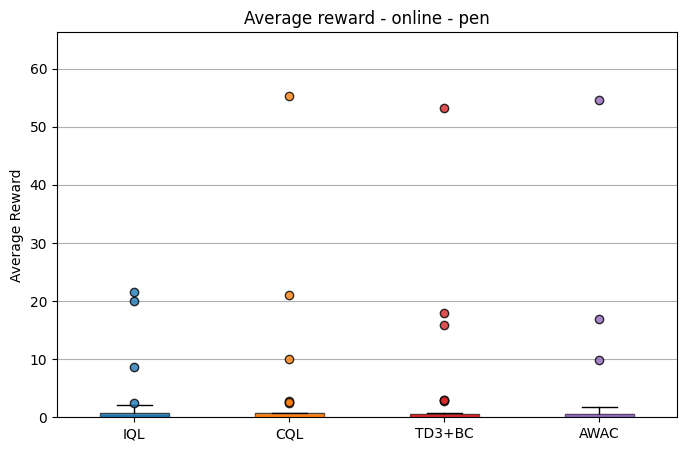

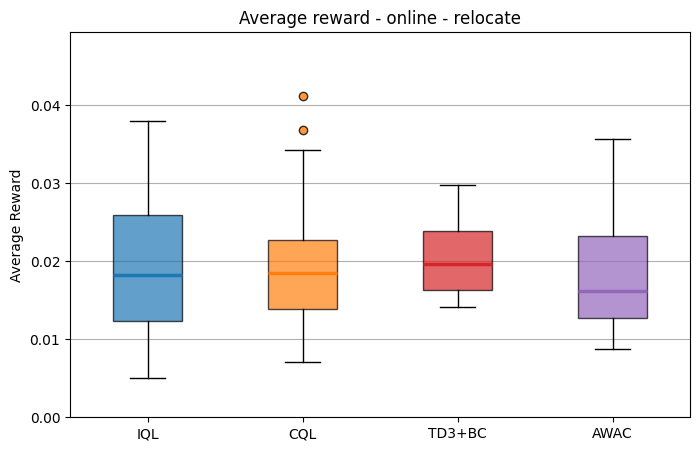

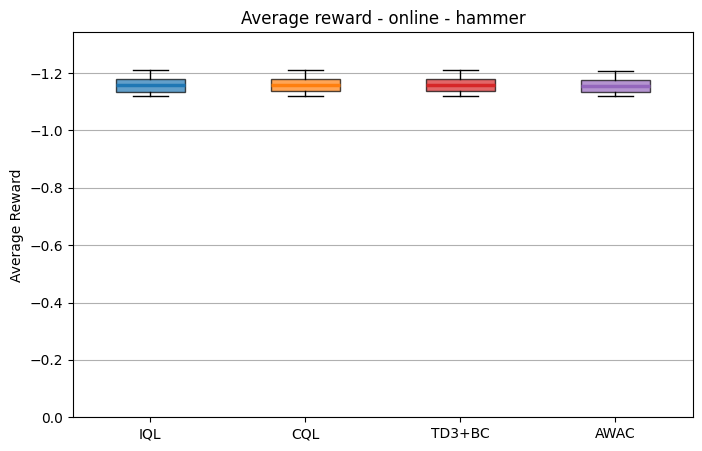

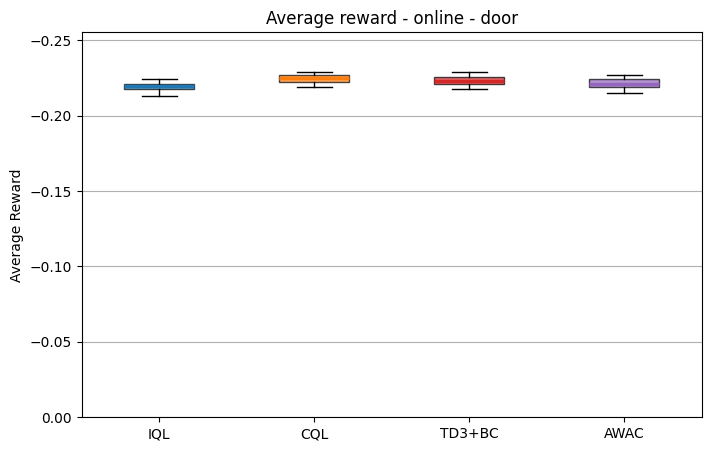

In [18]:
tasks = ['pen', 'relocate', 'hammer', 'door']

for t in range(4):
    fig, ax = plt.subplots(figsize=(8, 5))
    box = ax.boxplot(data[t], patch_artist=True, tick_labels=algorithms)
    
    # Colora box, mediane e outlier
    for patch, median_line, flier, algo in zip(box['boxes'], box['medians'], box['fliers'], algorithms):
        color = colors[algo]
        
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

        median_line.set_color(color)
        median_line.set_linewidth(2.5)

        flier.set_markerfacecolor(color)
        flier.set_markeredgecolor('black')
        flier.set_alpha(0.8)
        flier.set_markersize(6)

    ax.set_title(f'Average reward - {experiment} - {tasks[t]}')
    ax.set_ylabel('Average Reward')
    ax.grid(True, axis='y')
    ax.set_ylim(0, max(max(r) for r in data[t]) * 1.2)

    # Salva e mostra
    plt.savefig(f'results/{experiment}/rollout_rewards/{tasks[t]}.png', dpi=300, bbox_inches='tight')
    plt.show()